# *************************************************************
#Pontifícia Universidade Católica de Minas Gerais - PUC-Minas
# Pós Graduação em Ciência de Dados e Big Data
# Trabalho de Conclusão de Curso
## Um Modelo de Aprendizado de Máquina Supervisionado para Previsão de Quantidade de Público nos Jogos do Campeonato Brasileiro de Futebol

## Autor: Salomão Fernandes de Freitas Júnior
## ABRIL/2024


## ETAPA 3: Seleção do Modelo de Machine Learning

## Importação de Bibliotecas e Leitura de datasets





In [ ]:
# IMPORTAÇÃO DE BILBIOTECAS
# Para análise e visualização de dados
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Modelos de Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor, VotingRegressor
from sklearn.svm import SVR, LinearSVR  # Suport Vector Machine Regressor
from sklearn.naive_bayes import GaussianNB # Naive Bayes Gaussiano
from sklearn.neural_network import MLPRegressor # Rede Neural


# Estratégias de Validação
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, RepeatedStratifiedKFold

#Funções para procura de melhores parâmetros (Tunagem)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Métricas de avaliação
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

#Úteis
from datetime import datetime
import pytz  # timezone - fuso horário
import pickle # para salvamento e carregamento de modelos


# Definições de paths de arquivos
path_raiz_projeto = '/content/drive/MyDrive/Colab Notebooks/PUC Minas - TCC Ciência de Dados/'
path_datasets = path_raiz_projeto + 'Datasets/'

arquivo_dataset_entrada = path_datasets + 'brasileirao_serie_a_preparada_final_op2.csv'
arquivo_dataset_testes = path_datasets + 'brasileirao_dados_testes.csv'
arquivo_dataset_aplic = path_datasets + 'brasileirao_dados_aplicacao.csv'

path_resultados = path_raiz_projeto + 'Resultados/'
path_modelos = path_raiz_projeto + 'Modelos Salvos/'




In [ ]:
# Leitura do dataset preparado final, gerado no notebook 02-Preparação de Dados
df_brasileirao = pd.read_csv(arquivo_dataset_entrada, sep= ';', encoding='utf-8')

# Vamos reservar uma pequena parte do dataframe (aleatoriamente) para fazermos um teste final com o modelo selecionado com dados novos, os quais ele nunca teve contato
# Criando um DF com 5% dos dados (no nosso caso 280 linhas) e já salvando em um arquivo (será lido no final qndo for fazer o teste com o modelo selecionado)
parte_testes = df_brasileirao.sample(frac = 0.05).reset_index(drop = True)
parte_testes.to_csv(arquivo_dataset_testes, sep =';', encoding='utf-8', index = False) # index = false para não gerar a coluna do indice para o csv
# E o restante fica para aplicação nos modelos que testaremos. Vamos salvar também em um arquivo para garantir que a etapa do VotingRegressor também usará a mesma base
# Pois o treinamento dos modelos será demorado e pode ser que executemos as etapas em dias diferentes
df_brasileirao = df_brasileirao.drop(parte_testes.index).reset_index(drop = True)
df_brasileirao.to_csv(arquivo_dataset_aplic, sep =';', encoding='utf-8', index = False) # index = false para não gerar a coluna do indice para o csv
#display(parte_testes)

#Exibição de algumas linhas para observação
display(df_brasileirao.sample(6))

print('')
print('')

# Para nossa referência, vamos ver a estatística descritiva da variável publico, nossa variável alvo a ser predita
print('### Estatística Descritiva da variável publico ###')
print(df_brasileirao['publico'].describe().round(2))
print()
print()

# E o shape para lembrarmos a qtd de linhas e colunas
print('Shape')
df_brasileirao.shape

,rodada,points_mand_last_5,points_visit_last_5,colocacao_mandante_antes,colocacao_visitante_antes,grau_investimento_mandante,grau_investimento_visitante,publico,trimestre_3º Trimestre,trimestre_4º Trimestre,...,time_visitante_Paraná,time_visitante_Ponte Preta,time_visitante_Portuguesa,time_visitante_RB Bragantino,time_visitante_Santa Cruz,time_visitante_Santo André,time_visitante_Santos,time_visitante_Sport Recife,time_visitante_São Paulo,time_visitante_Vasco da Gama
206,0.621622,0.466667,0.200000,0.631579,0.789474,0.25,0.50,3833.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2284,0.351351,0.666667,0.466667,0.052632,0.842105,1.00,0.25,28511.0,1,0,...,0,0,0,0,0,0,0,0,0,0
5297,0.945946,0.466667,0.533333,0.842105,0.473684,0.25,0.50,45756.0,0,1,...,0,0,0,0,0,0,0,0,1,0
741,0.270270,0.666667,0.666667,0.315789,0.210526,1.00,0.75,21079.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1012,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.50,9422.0,0,0,...,0,0,0,0,0,0,0,0,0,1
906,0.729730,0.200000,0.600000,0.684211,0.263158,0.25,1.00,15897.0,0,1,...,0,0,0,0,0,0,0,0,0,0




### Estatística Descritiva da variável publico ###
count     5321.00
mean     18224.91
std      13335.56
min        286.00
25%       8484.00
50%      14526.00
75%      24701.00
max      82044.00
Name: publico, dtype: float64


Shape


(5321, 96)

## Primeiro teste com um modelo simples de Regressão Linear

In [ ]:
# Vamos aplicar um modelo de regressão linear, pois queremos prever uma variável numérica e contínua (publico)
from sklearn.linear_model import LinearRegression # Modelo
from sklearn.model_selection import train_test_split # Estratégia de Validação
from sklearn.metrics import mean_squared_error  # Métricas de avaliação
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Divide a base em variáveis de entrada e variável a ser predita
X = df_brasileirao.drop('publico', axis = 1) #variáveis de entrada - parâmetros. Todas menos publico
y = df_brasileirao['publico'] # variável a ser predita (target)

# Separando os dados da nossa base em teste e treino (Estratégia de Validação)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.25) #, random_state=25) # colocando 75% para treino e 25% para teste

# Ajuste do modelo nos dados de treino
regressao = LinearRegression()  # Modelo
regressao.fit(X_treino, y_treino) # treinamento com os dados separados para isso

# Utilizando o modelo ajustado (treinado) para predizer os dados separados para teste
y_pred = regressao.predict(X_teste)

# Métricas de Avaliação
mse = mean_squared_error(y_teste, y_pred)  # Erro quadrático médio (quanto menor, melhor)
rmse = np.sqrt(mse) # Raiz quadrada do mse (quanto menor, melhor)
mae = mean_absolute_error(y_teste, y_pred) # # Erro médio absoluto (quanto menor, melhor)
r2 = r2_score(y_teste, y_pred)  # R quadrado  (entre 0 e 1, quanto mais próximo de 1, melhor)

# Visualiza as métricas calculadas
print("MSE da Regressão Linear: {:.2f}".format(mse))
print("RMSE da Regressão Linear: {:.2f}".format(rmse))
print("MAE da Regressão Linear: {:.2f}".format(mae))
print("R2 da Regressão Linear: {:.2f}".format(r2))
print('')

# Visualiza um parte dos valores reais e dos respctivos valores preditos para comparação
print('Valores Reais   : ', list(y_teste[0:10].round(2)))
print('Valores Preditos: ', list(y_pred[0:10].round(2)))


MSE da Regressão Linear: 102251951.71
RMSE da Regressão Linear: 10111.97
MAE da Regressão Linear: 7265.80
R2 da Regressão Linear: 0.40

Valores Reais   :  [14501.0, 11189.0, 12089.0, 12755.0, 12138.0, 11195.0, 61767.0, 2411.0, 17825.0, 11142.0]
Valores Preditos:  [16287.85, 20334.38, 13986.3, 16846.42, 22142.17, 17351.34, 20567.96, 8016.09, 23311.25, 10017.46]


In [ ]:
## AGORA EXECUTANDO VÁRIAS VEZES PARA OBSERVAR O MELHOR RESULTADO ALCANÇADO
rep = 100
mses = [] # erro quadrático médio
rmses = [] # raiz quadrada do erro quadrático médio
maes = [] # erro abosoluto médio
r2s = [] # R quadrado



for i in range(rep):
  # Separando os dados da nossa base em teste e treino (Estratégia de Validação)
  X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.25) #, random_state=25) # colocando 75% para treino e 25% para teste

  # Ajuste do modelo nos dados de treino
  regressao = LinearRegression()  # Modelo
  regressao.fit(X_treino, y_treino) # treinamento com os dados separados para isso

  # Utilizando o modelo ajustado (treinado) para predizer os dados separados para teste
  y_pred = regressao.predict(X_teste)

  # Métricas de Avaliação
  mses.append(mean_squared_error(y_teste, y_pred))  # Erro quadrático médio (quanto menor, melhor)
  rmses.append(np.sqrt(mean_squared_error(y_teste, y_pred))) # Raiz quadrada do mse (quanto menor, melhor)
  maes.append(mean_absolute_error(y_teste, y_pred)) # # Erro médio absoluto (quanto menor, melhor)
  r2s.append(r2_score(y_teste, y_pred))  # R quadrado  (entre 0 e 1, quanto mais próximo de 1, melhor)

# Visualiza as métricas calculadas (médias)
print('### MÉDIAS DAS MÉTRICAS ##')
#print('MSE da Regressão Linear: {:.2f}'.format(sum(mse) / len(mse))) #format(np.mean(mse)))
mse = np.array(mses).mean().round(2)
rmse = np.array(rmses).mean().round(2)
mae = np.array(maes).mean().round(2)
r2 = np.array(r2s).mean().round(2)

print('MSE da Regressão Linear: ', mse)
print('RMSE da Regressão Linear: ', rmse)
print('MAE da Regressão Linear: ', mae)
print('R2 da Regressão Linear: ', r2)
print('')

# Melhores Valores
print('### MELHORES VALORES DAS MÉTRICAS ##')
print('MSE da Regressão Linear: {:.2f}'.format(min(mses)))
print('RMSE da Regressão Linear: {:.2f}'.format(min(rmses)))
print('MAE da Regressão Linear: {:.2f}'.format(min(maes)))
print('R2 da Regressão Linear: {:.2f}'.format(max(r2s)))
print('')


# Visualiza um parte dos valores reais e dos respctivos valores preditos para comparação
#print('Valores Reais   : ', list(y_teste[0:10].round(2)))
#print('Valores Preditos: ', list(y_pred[0:10].round(2)))


### MÉDIAS DAS MÉTRICAS ##
MSE da Regressão Linear:  3.600863252493158e+29
RMSE da Regressão Linear:  75473088101089.33
MAE da Regressão Linear:  3583139533410.72
R2 da Regressão Linear:  -2.0373517110626948e+21

### MELHORES VALORES DAS MÉTRICAS ##
MSE da Regressão Linear: 87262048.62
RMSE da Regressão Linear: 9341.42
MAE da Regressão Linear: 6907.60
R2 da Regressão Linear: 0.50



# APLICANDO MELHORES TÉCNICAS DE VALIDAÇÃO E TESTANDO VÁRIOS MODELOS E PARÂMETROS
#### O teste acima foi apenas uma primeira avaliação. No entanto não é tão simples assim. Precisamos aplicar outras técnicas de validação e testar vários algorítmos de machine learning, variando seus hiper-parâmetros

## TESTANDO VÁRIOS MODELOS COM HIPER-PARÂMETROS FIXOS

In [ ]:
 # Modelos
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

# Estratégias de Validação
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

# Métricas de avaliação
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import r2_score
#from sklearn.metrics import mean_absolute_error



In [ ]:
# Para verificar as métricas que podemos passar no cross validate
#from sklearn.metrics import get_scorer_names
#get_scorer_names()
#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [ ]:
# Comparando vários modelos
#Lista de Modelos que vamos Usar
modelos = [LinearRegression(fit_intercept = True),
           LinearRegression(fit_intercept = False),
           KNeighborsRegressor(n_neighbors = 5),
           KNeighborsRegressor(n_neighbors = 15),
           KNeighborsRegressor(n_neighbors = 35),
           DecisionTreeRegressor(max_depth = 3, min_samples_split=70),
           DecisionTreeRegressor(max_depth = 5, min_samples_split=70),
           DecisionTreeRegressor(max_depth = 5, min_samples_split=30),
           RandomForestRegressor(),
           ExtraTreesRegressor()]


# Lista com os nomes dos modelos respectivos
nomes = ['Regressão Linear (fit_intercept = True)',
         'Regressão Linear (fit_intercept = False)',
         'KNN - K = 5',
         'KNN - K = 15',
         'KNN - K = 35',
         'Árvore - Prof = 3, min amostras = 70',
         'Árvore - Prof = 5, min amostras = 70',
         'Árvore - Prof = 5, min amostras = 30',
         'Random Forrest',
         'ExtraTrees']


# a Nossa estratégia de validação será o kfold
validacao = KFold(n_splits = 10, shuffle = True)  # vai dividir em 10 partes para variar os dados de treino e teste (1 das partes é conjunto de teste, as demais são de treino)
                                                  # executa 10 rodadas com a mesma divisão, mas variando a parte de teste a cada rodada
                                                  # shuffle = True -> sempre que executar essa linha vai dividir aleatoriamente (diferente da execução anterior)

# Divide a base em variáveis de entrada e variável a ser predita
X = df_brasileirao.drop('publico', axis = 1) #variáveis de entrada - parâmetros. Todas menos publico
y = df_brasileirao['publico'] # variável a ser predita (target)

# Listas para guardar os valores das métricas dos testes
mses = [] # erro quadrático médio
rmses = [] # raiz quadrada do erro quadrático médio
maes = [] # erro abosoluto médio
r2s = [] # R quadrado




#Aplicando cada modelo e guardando os resultados
for modelo in modelos:
    print('### Rodando Modelo: ', modelo, '###')

    # Aplicamos o cross validate, pasando nosso modelo da iteração, a base (X e y), o modo de validação, e as métricas de queremos medir
    resultados = cross_validate(modelo, X, y, cv = validacao, scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error','r2'])

    # O cross validate retorna um dicionário com os resultados das métricas medidas nos testes pelo cross validate
    # Como ele executa 10 vezes (no nosso caso, parâmetro), então o resultado e um array numpy com as 10 medições de cada métrica
    # Nos obtemos a média para guardar para esse modelo da iteração
    mses.append(abs(resultados['test_neg_mean_squared_error'].mean()))
    rmses.append(abs(resultados['test_neg_root_mean_squared_error'].mean()))
    maes.append(abs(resultados['test_neg_mean_absolute_error'].mean()))
    r2s.append(abs(resultados['test_r2'].mean()))


#dicionário auxiliar para gerar um DF
dict_aux = {'MSE': mses, 'RMSE': rmses, 'MAE': maes, 'R2': r2s }

resultados = pd.DataFrame(dict_aux, index = nomes) # obtendo um DF a partir do dic, já colocando os nomes da lista como índice
resultados = resultados.sort_values(by = 'MAE').round(1) # Apresentado o DF de resultados, ordenado pelo MSE de teste, para rankear os modelos
resultados

### Rodando Modelo:  LinearRegression() ###
### Rodando Modelo:  LinearRegression(fit_intercept=False) ###
### Rodando Modelo:  KNeighborsRegressor() ###
### Rodando Modelo:  KNeighborsRegressor(n_neighbors=15) ###
### Rodando Modelo:  KNeighborsRegressor(n_neighbors=35) ###
### Rodando Modelo:  DecisionTreeRegressor(max_depth=3, min_samples_split=70) ###
### Rodando Modelo:  DecisionTreeRegressor(max_depth=5, min_samples_split=70) ###
### Rodando Modelo:  DecisionTreeRegressor(max_depth=5, min_samples_split=30) ###
### Rodando Modelo:  RandomForestRegressor() ###
### Rodando Modelo:  ExtraTreesRegressor() ###


,MSE,RMSE,MAE,R2
ExtraTrees,93848121.3,9676.1,6775.6,0.5
Random Forrest,90707595.4,9517.6,6829.6,0.5
Regressão Linear (fit_intercept = True),96071996.0,9788.9,7190.2,0.5
Regressão Linear (fit_intercept = False),96034018.1,9791.0,7193.4,0.4
KNN - K = 15,112469871.2,10598.1,7970.4,0.4
KNN - K = 35,112779170.0,10610.7,8105.2,0.4
KNN - K = 5,125435540.5,11189.5,8163.5,0.3
"Árvore - Prof = 5, min amostras = 30",126996459.9,11243.4,8496.9,0.3
"Árvore - Prof = 5, min amostras = 70",128566124.6,11331.1,8567.9,0.3
"Árvore - Prof = 3, min amostras = 70",141035455.9,11863.7,9144.0,0.2


## MELHORANDO NOSSO TESTE: TUNAGEM DE HIPER-PARÂMETROS
#### Aqui vamos acrescentar vários outros modelos para os testes
#### E realizar a tunagem de hiperparâmetros, onde conseguiremos testar várias configurações de hiperparâmetros para cada modelo
Tunagem de Hiperparâmetros nada mais é do que encontrar qual a melhor combinação de valores de parâmetros que passamos aos algoritmos no momento de seu treinamento. Alguns modelos tem poucos hiperparâmetros que se deseja tunar, outros têm muitos.

In [24]:
# Função para tunagem
# Recebe os parâmetros e devolve o melhor modelo (combinação de parâmetros) treinado, os melhores parâmetros , e o MAE respectivo (métrica)
def tunagem(modelo, features, targets, parametros, tipo = 'random', n_iter = 20, teste_fixo = True, params_teste_fixo = {}):
    # o n_iter só é usado se tipo = 'random'. significa o número de combinações que seram testadas no random.
    # se tipo = 'grid', sabemos que testa todas as combinações possíveis

    # As métricas que vamos querer que sejam calculadas
    metricas = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error','r2']

    # vai dividir em 10 partes para variar os dados de treino e teste (1 das partes é conjunto de teste, as demais são de treino)
    # executa 10 rodadas com a mesma divisão, mas variando a parte de teste a cada rodada
    #validacao = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)
    #validacao = RepeatedKFold(n_splits = 10, n_repeats = 3)
    validacao = RepeatedKFold(n_splits = 10, n_repeats = 1) # APENAS PARA SER MAIS RÁPIDO OS TESTES. MAS O CORRETO É O DE CIMA

    #https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    #como estamos usando multiplas métricas, então temos q usar o parâmetro refit = a metrica que será tomada para calculo do best_scorer e classificação do melhor modelo (combinação de parâmetros)
    if tipo == 'grid':
        # Increment o timeout, antes de executar o GridSearchCV
        #timeout=99999
        #GridSearchCV faz a validação cruzada para os vários modelos originados pela variação dos parâmetros, exibindo os resultados
        search = GridSearchCV(modelo, param_grid = parametros,
                                  scoring = metricas, cv = validacao,
                                  verbose = 10, n_jobs = 1, refit='neg_mean_squared_error')
    elif tipo == 'random':
        # Increment o timeout, antes de executar o RandomizedSearchCV
        #timeout=99999
        # RandomizedSearchCV faz essencialmente a mesma coisa do GridSearchCV, no entanto não testa todos as combinações de modelos,
        # e sim, apenas uma parte (aleatoriamente). Útil quando leva um tempo muito grande para analisar todas as combinações
        search = RandomizedSearchCV(modelo, param_distributions = parametros,
                                scoring = metricas, cv = validacao,
                                n_iter = n_iter, verbose = 10, n_jobs = 1, refit='neg_mean_squared_error')
    else:
        print('entrada inválida no argumento "tipo"')

    # Treina o modelo
    search.fit(features, targets)

    # obtém o melhor modelo (combinação de parâmetros)
    melhor_modelo = search.best_estimator_
    params_do_melhor = '{}'.format(search.best_params_)
    #score_do_melhor = '{:.4f}'.format(abs(search.best_score_)) # é o MSE do melhor (refit)
    score_do_melhor = round(abs(search.best_score_), 4) # é o MSE do melhor (refit)

    #print('\Erro absoluto médio: {:.4f}'.format(search.best_score_))
    #print('Melhores parâmetros: {}\n'.format(search.best_params_))

    #### TESTE FIXO. Isso aqui serve mais para o random, pois no grid faz teste exaustivo de tudo que foi passado em params
    #### CASO SE TENHA FEITO RANDOM ACIMA. COMO OS PARAMETROS TESTADOS SÃO ALEATÓRIOS,
    #### ENTÃO TEM ESSA OPÇÃO DE FAZER UM TESTE UM UM CONJUNTO DE PARAÂMETROS FIXO (NORMALEMLTE FAREMOS SEMPRE UM TESTE COM PARAMETROS DEFAULT
    if teste_fixo:
      # Faz um grid search com o modelo com parâmetros fixos para teste, para comparar com o melhor modelo gerado na busca acima
      default = GridSearchCV(modelo, param_grid = params_teste_fixo,
                                    scoring = metricas, cv = validacao,
                                    verbose = 10, n_jobs = 1, refit='neg_mean_squared_error')
      # Treina o modelo default
      default.fit(features, targets)
      score_do_default = round(abs(default.best_score_), 4) # é o MSE do melhor (refit)

      # faz o teste pra ver se o default é melhor
      if default.best_score_ > search.best_score_:
        search = default
        melhor_modelo = default.best_estimator_
        params_do_melhor = '{}'.format(default.best_params_)
        score_do_melhor = round(abs(default.best_score_), 4) # é o MSE do melhor (refit)
    ### FIM TESTE FIXO #######################################################################################


    # O search.cv_results_ retorna um dicionário com os resultados das métricas medidas nos testes
    # Como ele executa várias vezes (uma para cada combinação de parâmetros), então o resultado e um array numpy com as as medições de cada métrica em cada combinação
    # Para pegar as médias do melhor modelo, temos que saber o índice dele nos arrays. O índice do melhor está em search.best_index_
    # o mse será igual ao metrica_do_melhor pois estamos usando essa metrica no refit
    mse = '{:.4f}'.format(abs(search.cv_results_['mean_test_neg_mean_squared_error'][search.best_index_])) # o retorno do search.cv_results_['mean_test_neg_mean_squared_error'] é um array numpy
    rmse = '{:.4f}'.format(abs(search.cv_results_['mean_test_neg_root_mean_squared_error'][search.best_index_]))
    mae = '{:.4f}'.format(abs(search.cv_results_['mean_test_neg_mean_absolute_error'][search.best_index_]))
    r2 = '{:.4f}'.format(abs(search.cv_results_['mean_test_r2'][search.best_index_]))

    #display(pd.DataFrame(search.cv_results_))

    #retorna uma tupla (melhor_modelo, parametros do melhor, score do melhor, mse, rmse, mae, r2)
    return melhor_modelo, params_do_melhor, score_do_melhor, mse, rmse, mae, r2

In [32]:
# Divide a base em variáveis de entrada e variável a ser predita
X = df_brasileirao.drop('publico', axis = 1) #variáveis de entrada - parâmetros. Todas menos publico
y = df_brasileirao['publico'] # variável a ser predita (target)

# Comparando vários modelos
#Lista de Modelos que vamos Usar
modelos = [
           LinearRegression(),
           KNeighborsRegressor(),
           DecisionTreeRegressor(),
           RandomForestRegressor(),
           ExtraTreesRegressor(),
           GradientBoostingRegressor(),
           BaggingRegressor(),
           SVR(),         # Support Vector Machines
           LinearSVR(),   # Support Vector Machines
           GaussianNB(),  # Naive Bayes Gaussiano
           MLPRegressor(activation = 'relu',  batch_size=256, early_stopping=True, max_iter = 1000)   #Rede Neural. Já com uns parâmetros fixos
           ]

  #https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
  #https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
  #https://www.kaggle.com/code/juanmah/tactic-03-hyperparameter-optimization-bagging
  #https://www.kaggle.com/code/prashant111/bagging-vs-boosting


# Lista com os nomes dos modelos respectivos
nomes = [
         'LinearRegression()',
         'KNeighborsRegressor()',
         'DecisionTreeRegressor()',
         'RandomForrestRegressor()',
         'ExtraTreesRegressor()',
         'GradientBoostingRegressor()',
         'BaggingRegressor()',
         'SVR()',
         'LinearSVR()',
         'GaussianNB()',
         'MLPRegressor()'
         ]
# Lista com os parâmetros a serem testados dos modelos respectivos
# Tivemos o cuidado de sempre deixar o valor default do argumento na lista
parametros = [
              # para o LinearRegression()
              { 'fit_intercept' : [True, False] }, # Default (True)

              # para o KNeighborsRegressor()
              { 'n_neighbors' : [2, 3, 5, 8, 13, 20, 25, 35] }, # Default (5)

              # para o DecisionTreeRegressor()
              { 'max_depth' : [None, 3, 5, 10, 15, 40, 60, 80], 'min_samples_split' : [2, 5, 10, 12, 20, 50, 80, 110] },  # Default (None, 2)

              # para o RandomForrestRegressor()
              {'bootstrap': [True, False], 'max_depth': [None, 3, 5, 10, 15, 40, 60, 80], 'max_features': [1, 'sqrt'],
              'min_samples_leaf': [1, 2, 4, 7, 12], 'min_samples_split': [2, 5, 10, 12, 20, 50, 80, 110], 'n_estimators': [100, 200, 300, 500, 1000, 1500, 2000]}, #Default (True, None, 1, 1, 2, 100)
              #{'bootstrap': [True], 'max_depth': [None, 5, 30], 'max_features': [1, 5, 8],
              #'min_samples_leaf': [1, 12, 90], 'min_samples_split': [2, 10, 20], 'n_estimators': [100, 300, 1000]}, #Default (True, None, 1, 1, 2, 100)

              # para o ExtraTreesRegressor()
              {'bootstrap': [True, False], 'max_depth': [1, 2, 5, 8, 13, 21, 34, 53, 54, 55, 89, None], 'max_features': ['sqrt', 1, 2, 5, 8],
              'min_samples_leaf': [1, 2, 4, 7, 12, 21, 35, 55, 90], 'min_samples_split': [2, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377],
              'n_estimators': [100, 200, 300, 500, 1000, 1500, 2000]}, #Default (False, None, 1, 1, 2, 100)
              #{'bootstrap': [True], 'max_depth': [None, 5, 30], 'max_features': [1, 5, 8],
              #'min_samples_leaf': [1, 12, 90], 'min_samples_split': [2, 10, 20],
              #'n_estimators': [100, 300, 1000]}, #Default (False, None, 1, 1, 2, 100)

              # para o GradientBoostingRegressor()
              {'max_depth': [1, 2, 3, 5, 8, 13, 21, 34, 53, 54, 55, 89, None], 'max_features': ['sqrt', 1, 2, 5, 8, None],
              'min_samples_leaf': [1, 2, 4, 7, 12, 21, 35, 55, 90], 'min_samples_split': [2, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377],
              'n_estimators': [100, 200, 300, 500, 1000, 1500, 2000]}, #Default (3, None, 1, 2, 100)
              #{'max_depth': [3, 13, 53], 'max_features': [2, 8, None],
              #'min_samples_leaf': [1, 12, 90], 'min_samples_split': [2, 10, 20],
              #'n_estimators': [100, 300, 1000]}, #Default (3, None, 1, 2, 100)

              # para o BaggingRegressor()
              { 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800], 'max_features': [0.90, 0.92, 0.95, 1.0, 2.0],
                'bootstrap': [True, False], 'bootstrap_features': [True, False] }, # Default = (100, 1, True, False)
              #{ 'n_estimators': [100, 300, 1000], 'max_features': [1, 8, None],
              #  'bootstrap': [True], 'bootstrap_features': [False] },

              # para o SVR()
              { 'kernel' : ['rbf', 'sigmoid', 'linear'], 'degree' : [2, 3, 4] }, # Default (rbf, 3)

              # para o LinearSVR()
              {'fit_intercept' : [True, False] }, # Default (True)

              # para o GaussianNB()
              { 'var_smoothing' : np.logspace(-8,-10,3,base=10)}, # Default (1e-9)

              # para o MLPRegressor() # Rede Neural
              { 'hidden_layer_sizes': [(100,70,30), (30,70,100), (130, 100, 70, 50, 30, 10), (300, 200, 100, 50, 30, 10),  ],
                'learning_rate_init': np.append(np.logspace(-5,-1,10,base=10), [0.001]),  # aqui fazemos esse append para incluir o valor default (0.001)
                'alpha': np.logspace(-7,-3,10,base=10) }  #default = (100, 0.001, 0.0001 )
              #{ 'hidden_layer_sizes': [(100,70,30), (130, 100, 70, 50, 30, 10)],
              #  'learning_rate_init': np.logspace(-4,-2,3,base=10),
              #  'alpha': np.logspace(-5,-3,3,base=10) }  #default = (100, 0.001, 0.0001 )
             ]

# Deixa o default para todos, exceto o MLPRegressor (pois este vimos q não perfoma bem com o default)
# Isso é para sempre fazermos um teste com os paraâmetros default dos modelos (ou um conjunto fixo que queiramos semrpe incluir)
params_teste_fixo = [ {}, {}, {}, {}, {}, {}, {}, {}, {}, {},
                      { 'hidden_layer_sizes': [  (130, 100, 70, 50, 30, 10) ]  }  # Aqui não vou deixar o default,pq não deu bons resultados
                    ]


# Para guardar os resultados
melhores = {}


print('### Iniciando teste de parâmetros - Modelo por modelo de um total de {} modelos'.format(len(modelos), '###'))
inicio_geral = datetime.now().today().astimezone(pytz.timezone('America/Sao_Paulo'))  # Já q estou no google colab, especifico o fuso horário
print('Início geral em {}'.format(inicio_geral.strftime('%d/%m/%Y %H:%M:%S')))

# Execução da função Tunagem para cada modelo
#Aplicando cada modelo e guardando os resultados
for i in range(len(modelos)):
    print()
    print('### Rodando teste de parâmetros - Modelo {}/{}: {}'.format(i+1, len(modelos), nomes[i]), '###')
    inicio_modelo = datetime.now().today().astimezone(pytz.timezone('America/Sao_Paulo'))  # Já q estou no google colab, especifico o fuso horário
    print('Iniciado em {}'.format(inicio_modelo.strftime('%d/%m/%Y %H:%M:%S')))

    # Aplicamos a função de tunagem para o modelo da iteração
    # e guardamos o resultado (melhor configuração)
    #melhor = tunagem(modelos[i], X, y, parametros[i], tipo = 'grid') # ARGUMENTOS DEFAULT: tipo = 'random', n_iter = 20
    melhor = tunagem(modelos[i], X, y, parametros[i], tipo = 'random', n_iter = 9, teste_fixo = True, params_teste_fixo = params_teste_fixo[i]) # tipo = random não faz com todas as combinações (faz só com n_iter de combinações)

    melhores[nomes[i]] = [melhor[0], melhor[1], melhor[2], melhor[3], melhor[4], melhor[5], melhor[6] ]

    fim_modelo = datetime.now().today().astimezone(pytz.timezone('America/Sao_Paulo'))  # Já q estou no google colab, especifico o fuso horário
    print('Finalizado em {}'.format(fim_modelo.strftime('%d/%m/%Y %H:%M:%S')))
    print('Tempo gasto no modelo: {}'.format(fim_modelo - inicio_modelo))
    print('Tempo gasto desde o inicio: {}'.format(fim_modelo - inicio_geral))
    print('Melhor resultado: ', melhor)

fim_geral = datetime.now().today().astimezone(pytz.timezone('America/Sao_Paulo'))  # Já q estou no google colab, especifico o fuso horário
print()
print('### Finalizado teste de parâmetros - Modelo por modelo de um total de {} modelos'.format(len(modelos), '###'))
print('Finalizado em {}'.format(fim_modelo.strftime('%d/%m/%Y %H:%M:%S')))
print('Tempo total gasto: {}'.format(fim_geral - inicio_geral))

# Coloca os resultados dos modelos rankeados, em um DF, para observarmos
df_resultados_1 = pd.DataFrame(melhores, index = ['Modelo', 'Melhores Parâmetros', 'Scorer', 'MSE', 'RMSE', 'MAE', 'R2']).T
df_resultados_1 = df_resultados_1.sort_values(by = 'Scorer') # Apresentado o DF de resultados, ordenado pelo MAE, para rankear os modelos

print()
print()
print('############# Modelos rankeados pelo Scorer (métrica MSE) #############')
display(df_resultados_1[['Melhores Parâmetros', 'Scorer', 'MSE', 'RMSE', 'MAE', 'R2']])



# **************** TRECHO DE CÓDIGO NECESSÁRIO SOMENTE SE FOR EXECUTAR AS PRÓXIMAS CÉLULAS DE UM DIA PARA OUTRO *************************
# SALVANDO O RESULTADO EM UM ARQUIVO
# Só pq as vezes vai ficar rodando a noite. Só para prevenir em caso de desligamento, etc
df_resultados_1.to_csv(path_resultados + 'resultado_1_tunagem_comparacao.csv', sep =';', encoding='utf-8', index = True) # incluimos também a coluna do índice

# SALVANDO OS MODELOS (JÁ TREINADOS), PARA USO POSTERIOR
# O TEMPO DE TUNAGEM DE TODOS OS MODELOS TESTADOS PODE SER MUITO ALTO
# POR ISSO SALVAMOS OS 4 MELHORES MODELOS, PARA COLOCAR NO COMITÊ NO PRÓXIMO PASSO
# E OS DEMAIS PARA RESGATAR O DF df_resultados_1 (QUE SALVAMOS ACIMA)
# ASSIM, PODEMOS DEIXAR RODANDO E CONTINUAR POSTERIORMENTE A PARTIR DOS MODELOS SALVOS
for i in range(len(df_resultados_1)):
  arquivo_modelo = path_modelos + 'modelo_treinado_intermediario' + str(i+1) + '.sav'
  melhor_modelo = df_resultados_1.iloc[i]['Modelo']
  pickle.dump(melhor_modelo, open(arquivo_modelo, 'wb'))
# **************************************************************************************************************************************

SyntaxError: positional argument follows keyword argument (<ipython-input-32-7e1fb397d117>, line 18)

## Vamos também incluir um teste com comitê de modelos (combinação)
#### fazemos separadamente do procedimento acima (que testa todos os modelos em um laço)
#### porque justamente vamos pegar os 4 melhores do teste acima para fazer o comitê de modelos (VotingRegressor())
#### Após testar o VotingRegressor(), vamos incluir o seu resultado no dataframe com os outros modelos, para comparação. O melhor modelo aqui já será o nosso modelo selecionado para colocar em produção

In [30]:
# *************** ESSE TRECHO DE CÓDIGO SÓ É NECESSÁRIO CASO SE EXECUTE DE UM DIA PARA OUTRO ************************
# ***************  REFAZ O df_resultados_1, PARA DAR CONTINUIDADE À EXECUÇÃO ****************************************
# *************** E LÊ O df_brasileirao DO ARQUIVO SALVO ************************************************************
# PRIMEIRAMENTE Resgata o df_resultados_1 do arquivo salvo
# e os modelos salvos
# Fazemos isso, porque consideramos que esta etapa pode ser realizada em dia posterior ao teste dos modelos com tunagem
# Assim, salvamos o resulado em arquivo na etapa anterior e resgatamos aqui
df_resultados_1 = pd.read_csv(path_resultados + 'resultado_1_tunagem_comparacao.csv', sep= ';', encoding='utf-8').set_index('Unnamed: 0')
df_resultados_1.index.names=[None] # para a coluna do índice não ter nome nenhum

# resgatamos os modelos salvos
modelos = []
for i in range(len(df_resultados_1)): #range(4):
  arquivo_modelo = path_modelos + 'modelo_treinado_intermediario' + str(i+1) + '.sav'
  modelo_carregado = pickle.load(open(arquivo_modelo, 'rb'))
  # Vai colocando os modelos em uma lista
  modelos.append(modelo_carregado)

# Agora colocamos os modelos na coluna correspondente do DF Pois esta veio da planilha que estava salva (como string)
df_resultados_1['Modelo'] = modelos


# Leitura do dataset preparado final, que salvamos após separação de alguns dados para teste
# fazemos a leitura, porque esta célula poderá ser executada pode em dia posterior ao teste dos modelos com tunagem
df_brasileirao = pd.read_csv(arquivo_dataset_aplic, sep= ';', encoding='utf-8')

# Divide a base em variáveis de entrada e variável a ser predita
X = df_brasileirao.drop('publico', axis = 1) #variáveis de entrada - parâmetros. Todas menos publico
y = df_brasileirao['publico'] # variável a ser predita (target)
#*******************************************************************************************************************

In [31]:
# AGORA FAZ UM MODELO DE VOTING REGRESSOR COMBINANDO OS 4 MELHORES MODELOS DO RANKING ANTERIOR
# o VotingRegressor precisa dos modelos a serem combinados, como uma lista de tuplas (string do nome, modelo) como seu argumento
#https://www.geeksforgeeks.org/voting-regressor/

# Lê os 4 melhores modelos do teste anterior para botar no voting
best_models = [] # para ir compondo o parâmetro do VotingRegressor
modelos = []
for i in range(4):
  best_models.append( ('Modelo_' + str(i+1), df_resultados_1.iloc[i]['Modelo']) ) # Vai adicionando ao best_models a tupla (Nome, Modelo)

# Modelo VotingRegressor()
nome_voting = 'VotingRegressor()'
modelo_voting = VotingRegressor(best_models)
param = { } # parametros default

############ USANDO A FUNÇÃO DE TUNAGEM #########################
print()
print()
print('### Rodando comitê de modelos: {}'.format(nome_voting), '###')
inicio_modelo = datetime.now().today().astimezone(pytz.timezone('America/Sao_Paulo'))  # Já q estou no google colab, especifico o fuso horário
print('Iniciado em {}'.format(inicio_modelo.strftime('%d/%m/%Y %H:%M:%S')))

melhor = tunagem(modelo_voting, X, y, param, tipo = 'grid', teste_fixo = False) # teste_fixo = False, para não fazer teste adicional com parms fixos
result_melhor = { nome_voting : [melhor[0], melhor[1], melhor[2], melhor[3], melhor[4], melhor[5], melhor[6] ] }

fim_modelo = datetime.now().today().astimezone(pytz.timezone('America/Sao_Paulo'))  # Já q estou no google colab, especifico o fuso horário
print('Finalizado em {}'.format(fim_modelo.strftime('%d/%m/%Y %H:%M:%S')))
print('Tempo gasto no modelo: {}'.format(fim_modelo - inicio_modelo))
print('Resultado: ', melhor)
print()
print()

# Adiciona os resultados do modelo voting no df_resultados, rankeando
df_result_voting = pd.DataFrame(result_melhor, index = ['Modelo', 'Melhores Parâmetros', 'Scorer', 'MSE', 'RMSE', 'MAE', 'R2']).T
df_resultados_2 = pd.concat([df_resultados_1, df_result_voting ]).sort_values(by = 'Scorer')

# Exibe o df com modelos rankeados
print()
print()
print('############# Modelos rankeados pelo Scorer (métrica MSE) #############')
pd.options.display.float_format = '{:.4f}'.format #formata saída dos dados de ponto flutuante
display(df_resultados_2[['Melhores Parâmetros', 'Scorer', 'MSE', 'RMSE', 'MAE', 'R2']])
print()
print()

# SALVANDO O RESULTADO EM UM ARQUIVO APENAS PARA REGISTRO, MAS NÃO VAMOS PRECISAR DELE
# Só pq as vezes vai ficar rodando a noite. Só para prevenir em caso de desligamento, etc
df_resultados_2.to_csv(path_resultados + 'resultados_2_incluindo_voting.csv', sep =';', encoding='utf-8', index = False) # index = false para não gerar a coluna do indice para o csv

# SALVANDO O MELHOR MODELO (JÁ TREINADO), PARA USO POSTERIOR
# O TEMPO DE TUNAGEM/TREINAMENTO DO VOTING PODE SER MUITO ALTO
# POR ISSO SALVAMOS O MODELO PARA O NOSSO TETE FINAL COM DADOS NOVOS
# ASSIM, PODEMOS DEIXAR RODANDO E CONTINUAR POSTERIORMENTE A PARTIR DO MODELO SALVO
# ALÉM DISSO, ESSE JÁ É O NOSSO MELHOR MODELO, SELECIONADO PARA COLOCAR EM PRODUÇÃO
arquivo_modelo = path_modelos + 'modelo_treinado_final.sav'
melhor_modelo = df_resultados_2.iloc[0]['Modelo'] # Primeira linha e primeira coluna (['Modelo'])
pickle.dump(melhor_modelo, open(arquivo_modelo, 'wb'))




### Rodando comitê de modelos: VotingRegressor() ###
Iniciado em 22/04/2024 20:50:42
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10; 1/1] START ...........................................................


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 1/1] END  neg_mean_absolute_error: (test=-6375.702) neg_mean_squared_error: (test=-79213048.389) neg_root_mean_squared_error: (test=-8900.171) r2: (test=0.532) total time=  56.3s
[CV 2/10; 1/1] START ...........................................................


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 1/1] END  neg_mean_absolute_error: (test=-7502.552) neg_mean_squared_error: (test=-110112069.642) neg_root_mean_squared_error: (test=-10493.430) r2: (test=0.450) total time=  56.2s
[CV 3/10; 1/1] START ...........................................................


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 1/1] END  neg_mean_absolute_error: (test=-6755.107) neg_mean_squared_error: (test=-96111785.093) neg_root_mean_squared_error: (test=-9803.662) r2: (test=0.505) total time=  57.7s
[CV 4/10; 1/1] START ...........................................................


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 1/1] END  neg_mean_absolute_error: (test=-6533.646) neg_mean_squared_error: (test=-80854452.131) neg_root_mean_squared_error: (test=-8991.910) r2: (test=0.514) total time=  55.8s
[CV 5/10; 1/1] START ...........................................................


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 1/1] END  neg_mean_absolute_error: (test=-6418.682) neg_mean_squared_error: (test=-76777970.831) neg_root_mean_squared_error: (test=-8762.304) r2: (test=0.491) total time=  55.3s
[CV 6/10; 1/1] START ...........................................................


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 1/1] END  neg_mean_absolute_error: (test=-6707.613) neg_mean_squared_error: (test=-82313827.452) neg_root_mean_squared_error: (test=-9072.697) r2: (test=0.550) total time=  56.1s
[CV 7/10; 1/1] START ...........................................................


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-d7438d13c229>", line 23, in <cell line: 23>
    melhor = tunagem(modelo_voting, X, y, param, tipo = 'grid', teste_fixo = False) # teste_fixo = False, para não fazer teste adicional com parms fixos
  File "<ipython-input-24-606fc09ee0b9>", line 37, in tunagem
    search.fit(features, targets)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 874, in fit
    self._run_search(evaluate_candidates)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
    out = parallel(
  File "/usr/local/lib/python3.10/dis

TypeError: object of type 'NoneType' has no len()

## ACRESCENTANDO MODELOS DE REDES NEURAIS PARA COMPARAÇÃO E SELEÇÃO FINAL DO MELHOR MODELO

In [ ]:
# AGORA FAZEMOS O TESTE EM UM MODELOS DE REDES NEURAIS E COMPARAMOS O SEU DESEMPENHO COM OS OUTROS MODELOS

# Modelo com alguns parâmetros fixos
nome_rn = 'MLPRegressor()'
modelo_rn = MLPRegressor(batch_size=256, early_stopping=True)
# Parâmetros para tunagem
#param = {
#          'hidden_layer_sizes': [(100,), (70,100), (100,70), (100,70,30) ],
#          'learning_rate_init': np.logspace(-5,-1,10,base=10),
#          'alpha': np.logspace(-7,-3,10,base=10),
#        }

param = { 'hidden_layer_sizes': [ (130, 100, 70, 50, 30, 10) ] } #default = (100,)  #(130, 100, 70, 50, 30, 10)

############ USANDO A FUNÇÃO DE TUNAGEM #########################
print()
print()
print('### Rodando o modelo de redes neurais: {}'.format(nome_rn), '###')
inicio_modelo = datetime.now().today().astimezone(pytz.timezone('America/Sao_Paulo'))  # Já q estou no google colab, especifico o fuso horário
print('Iniciado em {}'.format(inicio_modelo.strftime('%d/%m/%Y %H:%M:%S')))

melhor = tunagem(modelo_rn, X_treino, y_treino, param, tipo = 'grid')
result_melhor = { nome_rn : [melhor[0], melhor[1], melhor[2], melhor[3], melhor[4], melhor[5], melhor[6] ] }

fim_modelo = datetime.now().today().astimezone(pytz.timezone('America/Sao_Paulo'))  # Já q estou no google colab, especifico o fuso horário
print('Finalizado em {}'.format(fim_modelo.strftime('%d/%m/%Y %H:%M:%S')))
print('Tempo gasto no modelo: {}'.format(fim_modelo - inicio_modelo))
print('Resultado: ', melhor)
print()
print()


# Adiciona os resultados do modelo voting no df_resultados, rankeando
df_result_rn = pd.DataFrame(result_melhor, index = ['Modelo', 'Melhores Parâmetros', 'Scorer', 'MSE', 'RMSE', 'MAE', 'R2']).T
df_resultados_3 = pd.concat([df_resultados_2, df_result_rn ]).sort_values(by = 'Scorer')

# Exibe o df com modelos rankeados
print()
print()
print('############# Modelos rankeados pelo Scorer (métrica MSE) #############')
display(df_resultados_3[['Melhores Parâmetros', 'Scorer', 'MSE', 'RMSE', 'MAE', 'R2']])
print()
print()



### Rodando o modelo de redes neurais: MLPRegressor() ###
Iniciado em 15/04/2024 20:42:38
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Finalizado em 15/04/2024 20:43:44
Tempo gasto no modelo: 0:01:05.957996
Resultado:  (MLPRegressor(batch_size=256, early_stopping=True,
             hidden_layer_sizes=(130, 100, 70, 50, 30, 10)), "{'hidden_layer_sizes': (130, 100, 70, 50, 30, 10)}", 93335510.8665, '93335510.8665', '9655.3802', '7007.3186', '0.4627')




############# Modelos rankeados pelo Scorer (métrica MSE) #############


,Melhores Parâmetros,Scorer,MSE,RMSE,MAE,R2
VotingRegressor(),{'weights': None},87876095.9996,87876095.9996,9368.9552,6801.5909,0.4944
MLPRegressor(),"{'hidden_layer_sizes': (130, 100, 70, 50, 30, ...",93335510.8665,93335510.8665,9655.3802,7007.3186,0.4627
RandomForrestRegressor(),{'bootstrap': True},93677512.0893,93677512.0893,9655.7695,7008.6212,0.4647
LinearRegression(),{'fit_intercept': True},95178133.2724,95178133.2724,9743.2568,7192.6678,0.4544
GradientBoostingRegressor(),"{'max_depth': 3, 'max_leaf_nodes': None}",96233657.2346,96233657.2346,9801.1877,7281.8994,0.4503
ExtraTreesRegressor(),{'bootstrap': False},96507561.0031,96507561.0031,9814.7008,6918.4964,0.4430
BaggingRegressor(),{'estimator': None},100234056.163,100234056.1630,10009.1903,7231.0497,0.4248
KNeighborsRegressor(),{'n_neighbors': 5},123642936.5508,123642936.5508,11112.5719,8224.2751,0.2890
DecisionTreeRegressor(),{'max_depth': None},178955949.1145,178955949.1145,13375.1564,9448.9698,0.0262
SVR(),{'kernel': 'rbf'},188183516.5591,188183516.5591,13703.4339,9872.2397,0.0767


MLPRegressor(batch_size=256, early_stopping=True,
             hidden_layer_sizes=(160, 130, 100, 70, 50, 30, 10))
Valores Preditos:  [32091.28, 14161.86, 15180.12, 13561.42, 29610.9, 11303.82, 8818.67, 15099.52, 7435.37, 26901.39]
Valores Reais   :  [21079.0, 4116.0, 18595.0, 20493.0, 48502.0, 7371.0, 7336.0, 9238.0, 1675.0, 23395.0]
MSE da Regressão Linear: 98039136.04
RMSE da Regressão Linear: 9901.47
MAE da Regressão Linear: 7022.09
R2 da Regressão Linear: 0.44




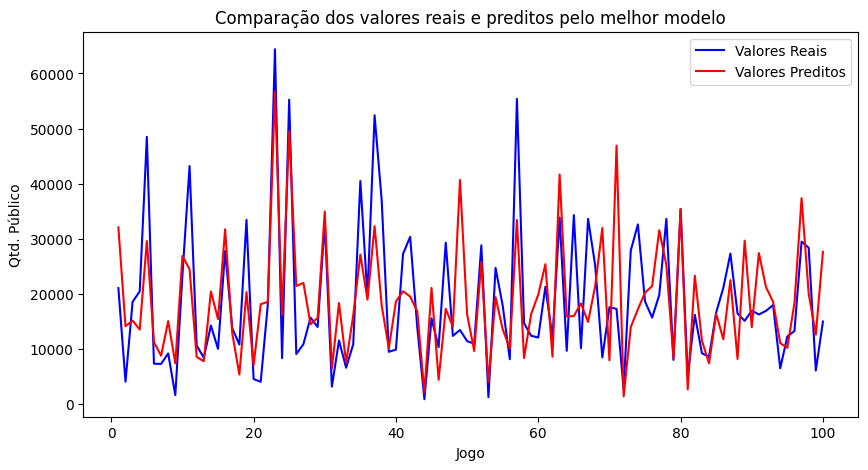

In [ ]:
# APÓS A INCLUSÃO DO MODELO DE REDES NEURAIS (MLP REGRESSOR)  NO ROL DE MODELOS,
# TESTANDO O MELHOR MODELO COM DADOS SEPARADOS PARA TESTE.
# Métricas de avaliação
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Pegando o melhor modelo
melhor_modelo = df_resultados_3.iloc[2]['Modelo']
print(melhor_modelo)

# Utilizando o modelo ajustado (treinado) para predizer os dados separados para teste
y_pred = melhor_modelo.predict(X_teste)

# Visualiza uma parte dos valores reais e dos respectivos valores preditos para comparação
print('Valores Preditos: ', list(y_pred[0:10].round(2)))
print('Valores Reais   : ', list(y_teste[0:10].round(2)))


# Calcula as Métricas de Avaliação com os dados separados para teste
mse = mean_squared_error(y_teste, y_pred)  # Erro quadrático médio (quanto menor, melhor)
rmse = np.sqrt(mse) # Raiz quadrada do mse (quanto menor, melhor)
mae = mean_absolute_error(y_teste, y_pred) # # Erro médio absoluto (quanto menor, melhor)
r2 = r2_score(y_teste, y_pred)  # R quadrado  (entre 0 e 1, quanto mais próximo de 1, melhor)

# Visualiza as métricas calculadas
print("MSE da Regressão Linear: {:.2f}".format(mse))
print("RMSE da Regressão Linear: {:.2f}".format(rmse))
print("MAE da Regressão Linear: {:.2f}".format(mae))
print("R2 da Regressão Linear: {:.2f}".format(r2))
print()
print()

# Plotar Gráfico preditos x reais (dispersão e linhas)
# Tamanho do Gráfico
plt.figure(figsize=(10,5))

#plt.scatter(y_teste, y_pred)
plt.plot( range(1, 101), y_teste[0:100], color = 'blue', label = 'Valores Reais') #, marker = '.' )
plt.plot(range(1, 101), y_pred[0:100], color = 'red', label = 'Valores Preditos') #, marker = '.' )

plt.title('Comparação dos valores reais e preditos pelo melhor modelo')
plt.xlabel('Jogo')
plt.ylabel('Qtd. Público')
plt.legend()
#plt.grid()


plt.show()

## O NOSSO MELHOR MODELO É O PRIMEIRO RANKEADO DO DATAFRAME ACIMA. ESTE SERÁ O MODELO SELECIONADO PARA LEVAR PARA PRODUÇÃO
### Primeiramente vamos testar o modelo com dados novos, com os quais o modelo nunca teve contato.
### Fazemos isso para ver os resultados e confirmar/garantir que não houve Overfitting, ou seja, que  o modelo performa bem (pelo menos similar à performance com os dados de nossa base histórica - dataset, que usamos no seu treinamento)
### Teoricamente, os métodos de validação usados (RepeatedKFold) já previnem o overfitting, no entanto, testamos aqui com os dados reservados para teste final, que são dados os quais são dados novos, que nosso modelo nunca teve contato

********** MELHOR MODELO **********
VotingRegressor(estimators=[('Modelo_1',
                             BaggingRegressor(max_features=0.92,
                                              n_estimators=400)),
                            ('Modelo_2', RandomForestRegressor()),
                            ('Modelo_3',
                             GradientBoostingRegressor(max_depth=21,
                                                       max_features=8,
                                                       min_samples_split=21,
                                                       n_estimators=300)),
                            ('Modelo_4',
                             MLPRegressor(alpha=1e-05, batch_size=256,
                                          early_stopping=True,
                                          hidden_layer_sizes=(100, 70, 30),
                                          learning_rate_init=0.01))])


********** MÉTRICAS DO MODELO **********
MSE: 17987928.38    RMSE: 42

,Qtd_Público_Predito,Qtd_Público_Real,Erro_Absoluto
0,41076.0000,51511.0000,10435.0000
1,9208.0000,7918.0000,1290.0000
2,33753.0000,46860.0000,13107.0000
3,6004.0000,4294.0000,1710.0000
4,26342.0000,34621.0000,8279.0000
...,...,...,...
275,12413.0000,12605.0000,192.0000
276,17399.0000,16758.0000,641.0000
277,5972.0000,4094.0000,1878.0000
278,7661.0000,8116.0000,455.0000




********** Comparando os valores reais e preditos em um gráfico **********


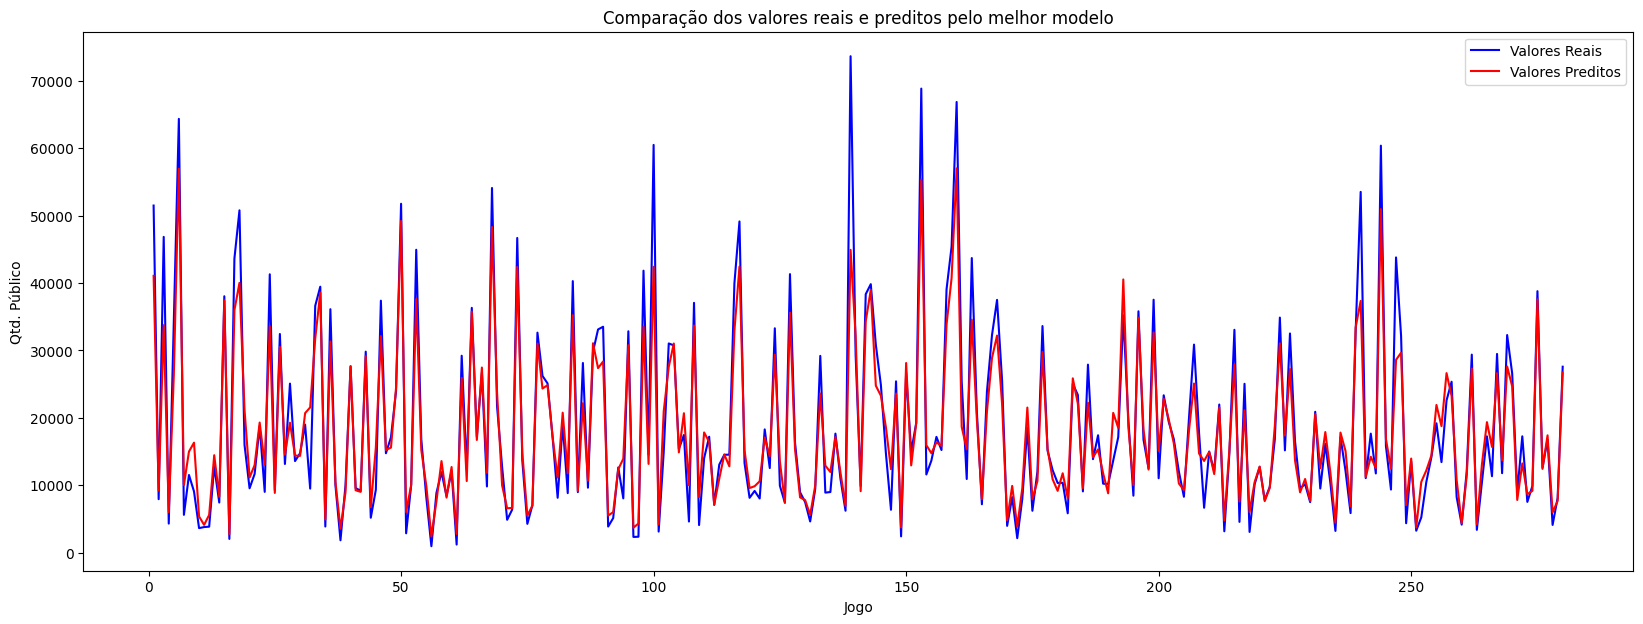

In [20]:
# TESTANDO O MELHOR MODELO COM DADOS NOVOS

# Pegando o melhor modelo
#melhor_modelo = df_resultados_2.iloc[0]['Modelo']
arquivo_modelo = path_modelos + 'modelo_treinado_final.sav'
melhor_modelo = pickle.load(open(arquivo_modelo, 'rb'))

# Exibe o melhor modelo
print('********** MELHOR MODELO **********')
print(melhor_modelo)
print()
print()

# Carregando dados de teste (O ARQUIVO SEPARADO PARA TESTES NO INÍCIO DESTE NOTEBOOK)
df_brasileirao_testes = pd.read_csv(arquivo_dataset_testes, sep= ';', encoding='utf-8')
# Divide a base em variáveis de entrada e variável a ser predita
X_teste = df_brasileirao_testes.drop('publico', axis = 1) #variáveis de entrada - parâmetros. Todas menos publico
y_teste = df_brasileirao_testes['publico'] # variável a ser predita (target)

# Utilizando o modelo ajustado (treinado) para predizer os dados separados para teste
y_pred = melhor_modelo.predict(X_teste)

# Calcula as Métricas de Avaliação com os dados separados para teste
mse = mean_squared_error(y_teste, y_pred)  # Erro quadrático médio (quanto menor, melhor)
rmse = np.sqrt(mse) # Raiz quadrada do mse (quanto menor, melhor)
mae = mean_absolute_error(y_teste, y_pred) # # Erro médio absoluto (quanto menor, melhor)
r2 = r2_score(y_teste, y_pred)  # R quadrado  (entre 0 e 1, quanto mais próximo de 1, melhor)

# Visualiza as métricas calculadas
print('********** MÉTRICAS DO MODELO **********')
print("MSE: {:.2f}".format(mse), "   RMSE: {:.2f}".format(rmse), "   MAE: {:.2f}".format(mae), "   R2: {:.2f}".format(r2))
print()
print()

# Visualiza uma parte dos valores reais e dos respectivos valores preditos para comparação
print('********** Comparação dos valores reais e preditos pelo melhor modelo **********')
#print('Valores Preditos: ', list(y_pred[0:100].round(0)))
#print('Valores Reais   : ', list(y_teste[0:100].round(0)))
df_comparacao_valores = pd.DataFrame({'Qtd_Público_Predito': list(y_pred.round(0)) , 'Qtd_Público_Real': list(y_teste.round(0))})
df_comparacao_valores['Erro_Absoluto'] = abs(df_comparacao_valores['Qtd_Público_Predito'] - df_comparacao_valores['Qtd_Público_Real'])
display(df_comparacao_valores)
print()
print()

# Plotar Gráfico preditos x reais (dispersão e linhas)
# Tamanho do Gráfico
plt.figure(figsize=(20,7))

#plt.scatter(y_teste, y_pred)
plt.plot( range(1, len(y_teste) + 1), y_teste, color = 'blue', label = 'Valores Reais') #, marker = '.' )
plt.plot(range(1, len(y_teste) + 1), y_pred, color = 'red', label = 'Valores Preditos') #, marker = '.' )

plt.title('Comparação dos valores reais e preditos pelo melhor modelo')
plt.xlabel('Jogo')
plt.ylabel('Qtd. Público')
plt.legend()
#plt.grid()

print('********** Comparando os valores reais e preditos em um gráfico **********')
plt.show()

## NOS TESTES REALIZADOS, VERIFICAMOS A EXCELENTE PERFORMANCE DO MODELO COM OS DADOS SEPARADOS PARA TESTES, COMO PODEMOS NOTAR NAS MÉTRICAS CALCULADAS E NO GRÁFICO DE REAIS X PREDITOS
### PODERÍAMOS AINDA VER A IMPORTÂNCIA DE VARIÁVEIS (FEATURE IMPORTANCES), PARA VER SE PODERÍAMOS EXCLUIR ALGUMA FEATURE DA BASE. NO ENTANTO, VAMOS MANTER O NOSSO MODELO SELECIONADO JÁ TREINADO E JÁ SALVO, E VAMOS LEVÁ-LO PARA UMA APLICAÇÃO EM PRODUÇÃO, QUE SERÁ USADA PARA ESTIMAR A QUANTIDADE DE PÚBLICO EM JOGOS DO CAMPEONATO BRASILEIRO, DE ACORDO COM OS DADOS (FEATURES) INFORMADOS POR UM USUÁRIO